In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

## Reading in Data

In [2]:
x_train = pd.read_csv(
  "../data/processed/x_train.csv", index_col=0, dtype=str
).reset_index(drop=True)
x_test = pd.read_csv(
  "../data/processed/x_test.csv", index_col=0, dtype=str
).reset_index(drop=True)
y_train = pd.read_csv(
  "../data/processed/y_train.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)
y_test = pd.read_csv(
  "../data/processed/y_test.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)

In [3]:
# Proper type conversion
def get_correct_types_x(df, numeric_cols):
    for col in ['deenergize_time', 'restoration_time']:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
    return df
# List of numeric columns to convert
numeric_cols = [
    'hftd_tier', 'total_affected', 'residential_affected',
    'longitude', 'latitude', 'total_pop', 'median_age', 'median_income',
    'white_pct', 'tmin_d-5', 'tmax_d-5', 'wspd_d-5', 'tmin_d-4', 'tmax_d-4',
    'wspd_d-4', 'tmin_d-3', 'tmax_d-3', 'wspd_d-3', 'tmin_d-2', 'tmax_d-2',
    'wspd_d-2', 'tmin_d-1', 'tmax_d-1', 'wspd_d-1', 'day_in_year'
]
x_train = get_correct_types_x(x_train, numeric_cols)
x_test = get_correct_types_x(x_test, numeric_cols)
rel_x_train = x_train[numeric_cols]
rel_x_test = x_test[numeric_cols]

In [4]:
# Scale to 0 mean, variance 1
scaler = StandardScaler()
scaler.fit(rel_x_train)
scaled_train_x = scaler.transform(rel_x_train)
scaled_test_x = scaler.transform(rel_x_test)

## Model Training

In [5]:
# Hyperparameter grid to search over
param_grid = { 
    'n_estimators': [100, 200, 300, 400],
    'max_features': [1 / 3, 'sqrt', 'log2'],
    'max_depth': [5, 6, 7, 8, 9, 10],
    'criterion': ['squared_error', 'absolute_error', 'poisson']
}
grid_size = np.array([len(value) for value in param_grid.values()]).prod()

In [6]:
rf = RandomForestRegressor(random_state=6)
# Try 25% of all possible combinations
# Running complete grid search would be too computationally intensive
# Opt instead to perform randomized search
# This code chunk takes ~10 minutes to run on my laptop
rf_cv = RandomizedSearchCV(
    estimator=rf, param_distributions=param_grid,
    n_iter=int(0.25 * grid_size), cv=5, random_state=229
)
rf_cv.fit(scaled_train_x, y_train)
preds = rf_cv.predict(scaled_test_x)

In [7]:
rf_cv.best_params_

{'n_estimators': 100,
 'max_features': 0.3333333333333333,
 'max_depth': 10,
 'criterion': 'squared_error'}

## Model Testing

In [8]:
# Use best hyperparameters from CV for final model
best_rf = RandomForestRegressor(
    n_estimators=rf_cv.best_params_['n_estimators'],
    max_features=rf_cv.best_params_['max_features'],
    max_depth=rf_cv.best_params_['max_depth'],
    criterion='squared_error',
    random_state=6
)
best_rf.fit(scaled_train_x, y_train)
best_preds = best_rf.predict(scaled_test_x)
np.savetxt("../data/predictions/rf_preds.csv", best_preds)

In [9]:
# Use R^2, RMSE as performance metrics
# Also get MAE
def calc_test_r2(pred_vals, true_vals, baseline_rmse):
    sse = mean_squared_error(pred_vals, true_vals) * len(true_vals)
    sst = (baseline_rmse ** 2) * len(true_vals)
    return (
        1 - sse / sst,
        np.sqrt(sse / len(true_vals)),
        mean_absolute_error(pred_vals, true_vals),
        mean_absolute_percentage_error(pred_vals, true_vals)
    )


In [10]:
baseline_rmse = np.sqrt(((y_test - y_test.mean()) ** 2).mean())
test_r2, rmse, mae, mape = calc_test_r2(best_preds, y_test, baseline_rmse)
train_devs = ((y_train - y_train.mean()) ** 2).sum()
print("Train RMSE: ", np.sqrt(mean_squared_error(y_train, best_rf.predict(scaled_train_x))))
print("Train R-Squared:", 1 - (mean_squared_error(y_train, best_rf.predict(scaled_train_x)) * len(y_train)) / train_devs)
print('Test R-Squared:', test_r2)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

Train RMSE:  411.37789633840646
Train R-Squared: 0.9159416873739582
Test R-Squared: 0.7796282107110201
RMSE: 741.7066670977055
MAE: 487.3720012698506
MAPE: 0.18583238578557326


## Variable Importance Plots

In [11]:
# Create permutations to see importance based MSE
# Feature importance
permutation_res = permutation_importance(
    best_rf, scaled_test_x, y_test, n_repeats=10, random_state=24, n_jobs=2
)
rf_importance = pd.Series(
    permutation_res.importances_mean, index=numeric_cols
)

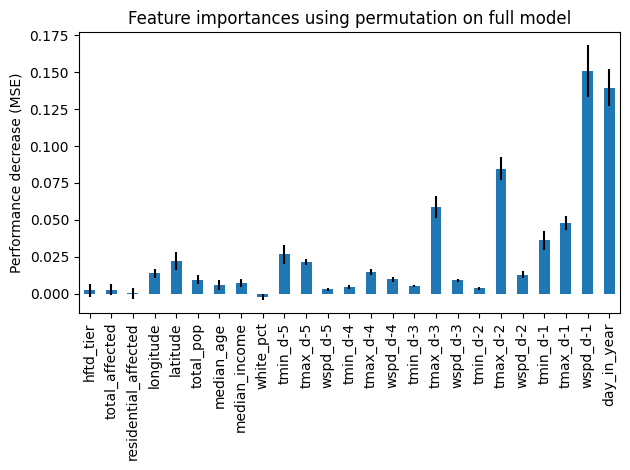

In [12]:
fig, ax = plt.subplots()
rf_importance.plot.bar(yerr=permutation_res.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Performance decrease (MSE)")
fig.tight_layout()
plt.show()